In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import bs4
from bs4 import BeautifulSoup
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio

# Goalkeeping

In [2]:
# IMPORTING GK DATA

response = requests.get('https://fbref.com/en/comps/676/keepersadv/UEFA-Euro-Stats')
soup = bs4.BeautifulSoup(response.content)
comments = soup.find_all(text=lambda text:isinstance(text, bs4.Comment))
commented_out_tables = [bs4.BeautifulSoup(cmt).find_all('table') for cmt in comments]
commented_out_tables = [tab[0] for tab in commented_out_tables if len(tab) == 1]
df_gk = pd.read_html(str(commented_out_tables[0]))[0]
main_tables = soup.find_all('table')
print(f'Total tables in main HTML: {len(main_tables)}')
print(f'Total tables in comments: {len(commented_out_tables)}')

if commented_out_tables:
    for i, table in enumerate(commented_out_tables):
        df_gk = pd.read_html(str(table))[0]
        # print(f"Table {i+1}:\n", df.head())
else:
    print("No tables found in comments.")

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_7684\4162489570.py:5: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  comments = soup.find_all(text=lambda text:isinstance(text, bs4.Comment))
C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_7684\4162489570.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  commented_out_tables = [bs4.BeautifulSoup(cmt).find_all('table') for cmt in comments]


Total tables in main HTML: 2
Total tables in comments: 1


In [3]:

# joining multiple index levels
df_gk.columns = ['_'.join(col) if 'Unnamed' not in col[0] else col[1] for col in df_gk.columns]

# getting rid of columns of no significance
df_gk = df_gk.drop(columns=['Rk', 'Matches'])

# removing country emojis
df_gk['Squad'] = df_gk['Squad'].str[3:]

# index 25 contains no data
df_gk = df_gk.drop(index=25)
df_gk = df_gk.reset_index(drop=True)

# fixing age format
df_gk['Age'] = df_gk['Age'].str.replace('-', '.', regex=False).astype(float)

# type conversion
columns_to_exclude = ['Player', 'Squad', 'Pos']
columns_to_convert = [col for col in df_gk.columns if col not in columns_to_exclude]
df_gk[columns_to_convert] = df_gk[columns_to_convert].apply(pd.to_numeric, errors='coerce')

print(df_gk.dtypes)
df_gk.to_csv("df_gk.csv")

Player                 object
Pos                    object
Squad                  object
Age                   float64
Born                    int64
90s                   float64
Goals_GA                int64
Goals_PKA               int64
Goals_FK                int64
Goals_CK                int64
Goals_OG                int64
Expected_PSxG         float64
Expected_PSxG/SoT     float64
Expected_PSxG+/-      float64
Expected_/90          float64
Launched_Cmp            int64
Launched_Att            int64
Launched_Cmp%         float64
Passes_Att (GK)         int64
Passes_Thr              int64
Passes_Launch%        float64
Passes_AvgLen         float64
Goal Kicks_Att          int64
Goal Kicks_Launch%    float64
Goal Kicks_AvgLen     float64
Crosses_Opp             int64
Crosses_Stp             int64
Crosses_Stp%          float64
Sweeper_#OPA            int64
Sweeper_#OPA/90       float64
Sweeper_AvgDist       float64
dtype: object


In [38]:
# dropping players who have played only one game
df_gk = df_gk[df_gk['90s'] > 1.9]

df_gk_ge = df_gk[df_gk['Player'] == 'Giorgi Mamardashvili'].copy()
df_gk_other = df_gk[df_gk['Player'] != 'Giorgi Mamardashvili'].copy()

# plot

df_gk['Rank'] = df_gk['Expected_PSxG+/-'].rank(ascending=False)
gk_fig1 = px.bar(df_gk.sort_values(by='Rank'), x='Player', y='Expected_PSxG+/-',
              title='Ranking of Goalkeepers by xG Minus Goals Conceded - Best Shot-Stopping Performance',
              labels={'Expected_PSxG+/-': 'Expected PSxG +/-', 'Player': 'Goalkeeper'},
              hover_data=['Player', 'Squad', 'Rank'])
for i in range(len(gk_fig1.data[0].x)):
    if gk_fig1.data[0].x[i] == 'Giorgi Mamardashvili':
        gk_fig1.data[0].marker.color = ['#329952' if x == 'Giorgi Mamardashvili' else '#3b7eeb' for x in gk_fig1.data[0].x]
gk_fig1.show()

gk_fig1.write_html("gk_fig1.html")

In [39]:
def visualize_comparison_passing_metrics_radar(df_gk):
    # data for Giorgi Mamardashvili
    df_gk_ge = df_gk[df_gk['Player'] == 'Giorgi Mamardashvili']
    if not df_gk_ge.empty:
        metrics_ge = {
            'Passes Attempted (GK)': df_gk_ge['Passes_Att (GK)'].values[0],
            'Launched Passes Completed': df_gk_ge['Launched_Cmp'].values[0],
            'Launched Passes Attempted': df_gk_ge['Launched_Att'].values[0],
            'Average Pass Length': df_gk_ge['Passes_AvgLen'].values[0],
            'Goal Kicks Attempted': df_gk_ge['Goal Kicks_Att'].values[0],
            'Goal Kicks Launch %': df_gk_ge['Goal Kicks_Launch%'].values[0],
            'Average Goal Kick Length': df_gk_ge['Goal Kicks_AvgLen'].values[0]
        }

    # data for other goalkeepers
    df_gk_other = df_gk[df_gk['Player'] != 'Giorgi Mamardashvili']
    if not df_gk_other.empty:
        avg_metrics_other = {
            'Passes Attempted (GK)': df_gk_other['Passes_Att (GK)'].mean(),
            'Launched Passes Completed': df_gk_other['Launched_Cmp'].mean(),
            'Launched Passes Attempted': df_gk_other['Launched_Att'].mean(),
            'Average Pass Length': df_gk_other['Passes_AvgLen'].mean(),
            'Goal Kicks Attempted': df_gk_other['Goal Kicks_Att'].mean(),
            'Goal Kicks Launch %': df_gk_other['Goal Kicks_Launch%'].mean(),
            'Average Goal Kick Length': df_gk_other['Goal Kicks_AvgLen'].mean()
        }


        gk_fig2 = go.Figure()


        gk_fig2.add_trace(go.Scatterpolar(
            r=list(metrics_ge.values()),
            theta=list(metrics_ge.keys()),
            mode='lines+markers',
            line=dict(color='darkgreen'),
            marker=dict(color='darkgreen'),
            name='Giorgi Mamardashvili'
        ))

        gk_fig2.add_trace(go.Scatterpolar(
            r=list(avg_metrics_other.values()),
            theta=list(avg_metrics_other.keys()),
            mode='lines+markers',
            line=dict(color='darkblue'),
            marker=dict(color='darkblue'),
            name='Average of Other Goalkeepers'
        ))

        gk_fig2.update_layout(
            title='Comparison of Ball Distribution Metrics: Giorgi Mamardashvili vs Average of Other Goalkeepers',
            polar=dict(
                radialaxis=dict(visible=True, range=[0, max(max(metrics_ge.values()), max(avg_metrics_other.values()))])
            ),
            showlegend=True,
            plot_bgcolor='white',
            paper_bgcolor='white'
        )

        gk_fig2.show()
        gk_fig2.write_html("gk_fig2.html")

visualize_comparison_passing_metrics_radar(df_gk)

In [40]:
def create_pie_chart(data, colors, title):
    fig = go.Figure()
    fig.add_trace(go.Pie(
        labels=data.index,
        values=data.values,
        marker=dict(colors=colors),
        textinfo='label+percent',
        hole=0.3
    ))
    fig.update_layout(
        title=title,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(t=50, b=50, l=50, r=50)
    )
    return fig

def create_goalkeeper_pie_charts(df_gk):
    global gk_fig3x1, gk_fig3x2
    
    df_gk_ge = df_gk[df_gk['Player'] == 'Giorgi Mamardashvili']
    if not df_gk_ge.empty:
        metrics_ge = {
            'Passes Attempted (GK)': df_gk_ge['Passes_Att (GK)'].values[0],
            'Throws Attempted': df_gk_ge['Passes_Thr'].values[0]
        }
        colors_ge = ['#83c798', '#329952']
        gk_fig3x1 = create_pie_chart(pd.Series(metrics_ge), colors_ge, 'Throwing vs Passing: What\'s Preferred? Giorgi Mamardashvili\'s Metrics')
        gk_fig3x1.write_html('gk_fig3x1.html')

    df_gk_other = df_gk[df_gk['Player'] != 'Giorgi Mamardashvili']
    if not df_gk_other.empty:
        avg_metrics = {
            'Passes Attempted (GK)': df_gk_other['Passes_Att (GK)'].mean(),
            'Throws Attempted': df_gk_other['Passes_Thr'].mean()
        }
        colors_avg = ['#6b96db', '#2b60b5']
        gk_fig3x2 = create_pie_chart(pd.Series(avg_metrics), colors_avg, 'Average Metrics of Other Goalkeepers')
        gk_fig3x2.write_html('gk_fig3x2.html')

    if 'gk_fig3x1' in globals():
        gk_fig3x1.show()
    if 'gk_fig3x2' in globals():
        gk_fig3x2.show()

create_goalkeeper_pie_charts(df_gk)

In [41]:
def visualize_defensive_actions_distance_individual(df_gk):
    df_gk_sorted = df_gk[['Player', 'Sweeper_AvgDist']].sort_values(by='Sweeper_AvgDist')

    players = df_gk_sorted['Player']
    distances = df_gk_sorted['Sweeper_AvgDist']

    gk_fig4 = go.Figure()

    gk_fig4.add_trace(go.Bar(
        x=players,
        y=distances,
        marker_color=['#329952' if player == 'Giorgi Mamardashvili' else '#6b96db' for player in players],
        name='Goalkeepers'
    ))

    gk_fig4.update_layout(
        title='Average Distance From Goal of Defensive Actions',
        xaxis_title='Goalkeepers',
        yaxis_title='Average Distance (yards)',
        xaxis_tickangle=-45,
        plot_bgcolor='white',
        paper_bgcolor='white',
        height=600
    )

    gk_fig4.add_shape(
        type="line",
        x0=-0.5,
        y0=6,
        x1=len(players) - 0.5,
        y1=6,
        line=dict(color="black", width=2, dash="dash")
    )

    gk_fig4.add_shape(
        type="line",
        x0=-0.5,
        y0=18,
        x1=len(players) - 0.5,
        y1=18,
        line=dict(color="black", width=2, dash="dash")
    )

    gk_fig4.add_annotation(
        x=len(players) + 0.5,
        y=6,
        text="Goal Area",
        showarrow=False,
        font=dict(color="black")
    )

    gk_fig4.add_annotation(
        x=len(players) + 0.5,
        y=18,
        text="Penalty Area",
        showarrow=False,
        font=dict(color="black")
    )

    gk_fig4.show()
    gk_fig4.write_html("gk_fig4.html")

visualize_defensive_actions_distance_individual(df_gk)

# Defending

In [4]:
# IMPORTING DEFENSE STATS

response = requests.get('https://fbref.com/en/comps/676/defense/UEFA-Euro-Stats')
soup = bs4.BeautifulSoup(response.content)
comments = soup.find_all(text=lambda text:isinstance(text, bs4.Comment))
commented_out_tables = [bs4.BeautifulSoup(cmt).find_all('table') for cmt in comments]
commented_out_tables = [tab[0] for tab in commented_out_tables if len(tab) == 1]
df_def = pd.read_html(str(commented_out_tables[0]))[0]
main_tables = soup.find_all('table')
print(f'Total tables in main HTML: {len(main_tables)}')
print(f'Total tables in comments: {len(commented_out_tables)}')

if commented_out_tables:
    for i, table in enumerate(commented_out_tables):
        df_def = pd.read_html(str(table))[0]
else:
    print("No tables found in comments.")

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_7684\4261112180.py:5: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  comments = soup.find_all(text=lambda text:isinstance(text, bs4.Comment))
C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_7684\4261112180.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  commented_out_tables = [bs4.BeautifulSoup(cmt).find_all('table') for cmt in comments]


Total tables in main HTML: 2
Total tables in comments: 1


In [5]:
# joining multiple index levels
df_def.columns = ['_'.join(col) if 'Unnamed' not in col[0] else col[1] for col in df_def.columns]

# getting rid of columns of no significance
df_def = df_def.drop(columns=['Rk', 'Matches'])

# removing country emojis
df_def['Squad'] = df_def['Squad'].str[3:]

# index 25 contains no data
df_def = df_def.drop(index=25)
df_def = df_def.reset_index(drop=True)

# handling fully empty rows
df_def = df_def[df_def['Squad'] != 'ad']

# type conversion
columns_to_exclude = ['Player', 'Squad', 'Pos']
columns_to_convert = [col for col in df_def.columns if col not in columns_to_exclude]
df_def[columns_to_convert] = df_def[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_def.head()

,Player,Pos,Squad,Age,Born,90s,Tackles_Tkl,Tackles_TklW,Tackles_Def 3rd,Tackles_Mid 3rd,...,Challenges_Att,Challenges_Tkl%,Challenges_Lost,Blocks_Blocks,Blocks_Sh,Blocks_Pass,Int,Tkl+Int,Clr,Err
0,Che Adams,FW,Scotland,27,1996,2.3,2,1,1,1,...,1,100.0,0,2,0,2,1,3,0,0
1,Michel Aebischer,DF,Switzerland,27,1997,5.3,4,3,2,2,...,11,9.1,10,3,1,2,2,6,7,0
2,Arlind Ajeti,DF,Albania,30,1993,3.0,1,0,0,1,...,3,33.3,2,5,4,1,6,7,13,0
3,Manuel Akanji,DF,Switzerland,28,1995,5.3,2,2,2,0,...,2,50.0,1,6,6,0,4,6,22,0
4,Samet Akaydın,DF,Türkiye,29,1994,3.7,8,4,8,0,...,8,75.0,2,5,5,0,7,15,16,0


In [44]:
df_georgia = df_def[df_def['Squad'] == 'Georgia'].copy()
df_georgia['Total_Def_Actions'] = df_georgia['Tackles_Tkl'] + df_georgia['Blocks_Blocks'] + df_georgia['Int'] + df_georgia['Clr']

# plotting TREEMAP
def_fig1 = px.treemap(df_georgia, path=['Squad', 'Player'], values='Total_Def_Actions',
                  title='Georgian Players with Most Total Defensive Actions',
                  color='Squad',
                  color_discrete_map={'Georgia': '#329952'},
                  hover_data={'Tackles_Tkl': True, 'Blocks_Blocks': True, 'Int': True, 'Clr': True})

def_fig1.update_traces(textinfo='label+value+percent entry')

def_fig1.show()
def_fig1.write_html("def_fig1.html")

In [45]:
df_def['Total_Tackles'] = df_def['Tackles_Def 3rd'] + df_def['Tackles_Mid 3rd'] + df_def['Tackles_Att 3rd']
df_def['Weighted_Position'] = (df_def['Tackles_Def 3rd'] * 0 + 
                               df_def['Tackles_Mid 3rd'] * 0.5 + 
                               df_def['Tackles_Att 3rd'] * 1) / df_def['Total_Tackles']

df_grouped = df_def.groupby('Squad').agg({'Weighted_Position': 'mean'}).reset_index()

df_grouped = df_grouped.sort_values(by='Weighted_Position')

def_fig2 = px.scatter(df_grouped, x='Weighted_Position', y='Squad',
                  title='Weighted Average Position of Tackles Across Pitch Thirds by Team',
                  labels={'Weighted_Position': 'Pitch Third', 'Squad': 'Team'},
                  hover_data=['Weighted_Position'])

def_fig2.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
def_fig2.update_traces(marker=dict(color=df_grouped['Squad'].apply(lambda x: '#32e63e' if x == 'Georgia' else '#2c67c7')))

def_fig2.update_layout(
    xaxis=dict(
        title='Pitch Third',
        range=[-0.1, 1.1],
        tickvals=[],
    ),
    yaxis=dict(
        automargin=True,
        title=dict(standoff=10),
        range=[-0.5, len(df_grouped) - 0.5]
    ),
    shapes=[
        # shaded area for defensive third (0 to 0.33)
        dict(
            type='rect',
            x0=0,
            x1=0.33,
            y0=-0.5,
            y1=len(df_grouped) - 0.5,
            fillcolor='rgba(255, 0, 0, 0.2)',
            line=dict(color='rgba(255, 0, 0, 0)')
        ),
        # shaded area for middle third (0.33 to 0.67)
        dict(
            type='rect',
            x0=0.33,
            x1=0.67,
            y0=-0.5,
            y1=len(df_grouped) - 0.5,
            fillcolor='rgba(255, 165, 0, 0.2)',
            line=dict(color='rgba(255, 165, 0, 0)')
        ),
        # shaded area for attacking third (0.67 to 1)
        dict(
            type='rect',
            x0=0.67,
            x1=1,
            y0=-0.5,
            y1=len(df_grouped) - 0.5,
            fillcolor='rgba(0, 0, 255, 0.2)',
            line=dict(color='rgba(0, 0, 255, 0)')
        )
    ],
    annotations=[
        dict(
            x=0.165,
            y=-0.05,
            xref='x',
            yref='y',
            text='Def 3rd',
            showarrow=False,
            font=dict(size=12, color='black')
        ),
        dict(
            x=0.5,
            y=-0.05,
            xref='x',
            yref='y',
            text='Mid 3rd',
            showarrow=False,
            font=dict(size=12, color='black')
        ),
        dict(
            x=0.835,
            y=-0.05,
            xref='x',
            yref='y',
            text='Att 3rd',
            showarrow=False,
            font=dict(size=12, color='black')
        )
    ],
    margin=dict(l=200),
    height=800
)

def_fig2.show()
def_fig2.write_html("def_fig2.html")

# Passing

In [46]:
# IMPORTING PASSING STATS

response = requests.get('https://fbref.com/en/comps/676/passing/UEFA-Euro-Stats')
soup = bs4.BeautifulSoup(response.content)
comments = soup.find_all(text=lambda text:isinstance(text, bs4.Comment))
commented_out_tables = [bs4.BeautifulSoup(cmt).find_all('table') for cmt in comments]
commented_out_tables = [tab[0] for tab in commented_out_tables if len(tab) == 1]
df_pass = pd.read_html(str(commented_out_tables[0]))[0]
main_tables = soup.find_all('table')
print(f'Total tables in main HTML: {len(main_tables)}')
print(f'Total tables in comments: {len(commented_out_tables)}')

if commented_out_tables:
    for i, table in enumerate(commented_out_tables):
        df_pass = pd.read_html(str(table))[0]
else:
    print("No tables found in comments.")

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\754971183.py:5: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\754971183.py:6: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



Total tables in main HTML: 2
Total tables in comments: 1


In [47]:
# joining multiple index levels
df_pass.columns = ['_'.join(col) if 'Unnamed' not in col[0] else col[1] for col in df_pass.columns]

# getting rid of columns of no significance
df_pass = df_pass.drop(columns=['Rk', 'Matches'])

# removing country emojis
df_pass['Squad'] = df_pass['Squad'].str[3:]

# index 25 contains no data
df_pass = df_pass.drop(index=25)
df_pass = df_pass.reset_index(drop=True)

# handling fully empty rows
df_pass = df_pass[df_pass['Squad'] != 'ad']

# type conversion
columns_to_exclude = ['Player', 'Squad', 'Pos']
columns_to_convert = [col for col in df_pass.columns if col not in columns_to_exclude]
df_pass[columns_to_convert] = df_pass[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_pass.head()

,Player,Pos,Squad,Age,Born,90s,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,...,Long_Cmp%,Ast,xAG,Expected_xA,Expected_A-xAG,KP,1/3,PPA,CrsPA,PrgP
0,Che Adams,FW,Scotland,27,1996,2.3,27,31,87.1,386,...,33.3,0,0.1,0.2,-0.1,2,2,0,0,2
1,Michel Aebischer,DF,Switzerland,27,1997,5.3,221,252,87.7,3316,...,62.5,2,1.2,1.0,0.8,6,17,7,0,28
2,Arlind Ajeti,DF,Albania,30,1993,3.0,93,112,83.0,1654,...,47.1,0,0.0,0.0,0.0,0,4,0,0,5
3,Manuel Akanji,DF,Switzerland,28,1995,5.3,304,331,91.8,5658,...,79.5,0,0.0,0.1,0.0,1,21,0,0,25
4,Samet Akaydın,DF,Türkiye,29,1994,3.7,185,206,89.8,3262,...,61.9,0,0.0,0.1,0.0,0,18,0,0,15


C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\2578598439.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\2578598439.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



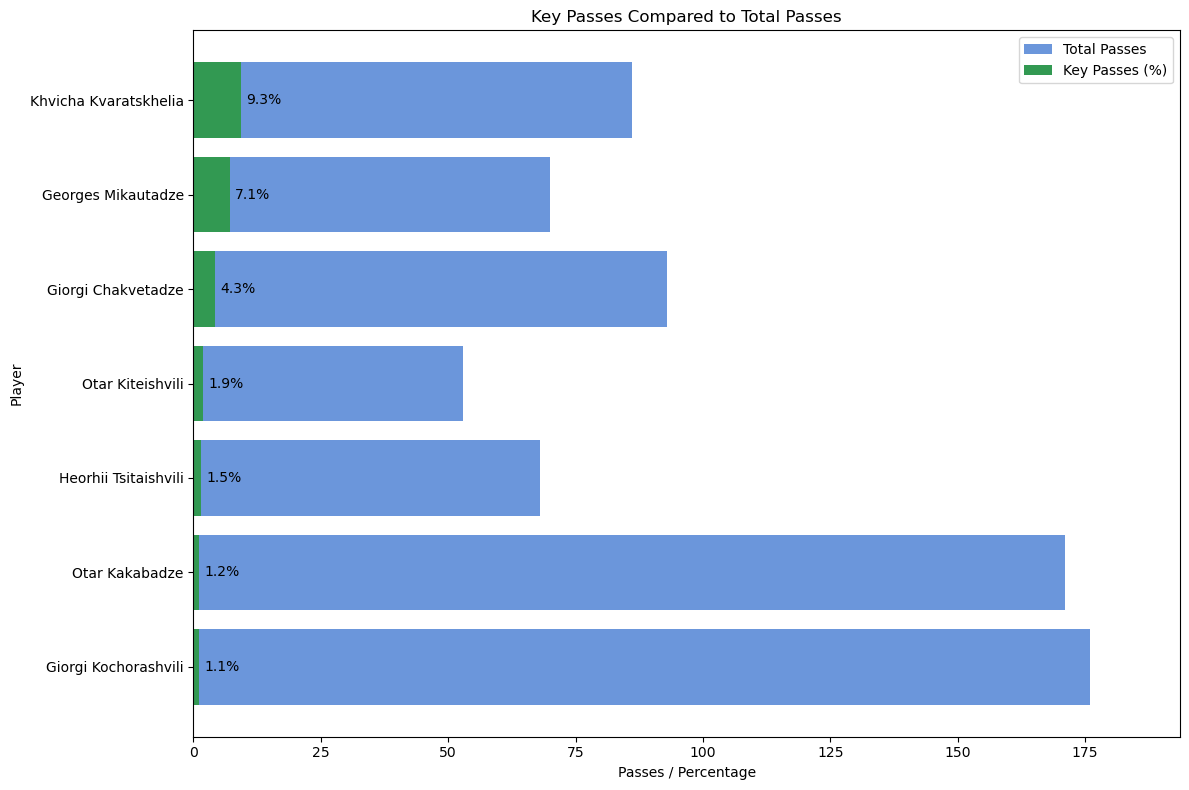

In [48]:
georgia_players = df_pass[df_pass['Squad'] == 'Georgia']
georgia_players['KeyPassRatio'] = georgia_players['KP'] / georgia_players['Total_Att']
georgia_players['KeyPassPercentage'] = georgia_players['KeyPassRatio'] * 100

georgia_players = georgia_players[georgia_players['KeyPassPercentage'] > 0]

georgia_players = georgia_players.sort_values(by='KeyPassRatio', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

bars_total_passes = ax.barh(georgia_players['Player'], georgia_players['Total_Att'], color='#6b96db', label='Total Passes')

bars_key_passes = ax.barh(georgia_players['Player'], georgia_players['KeyPassPercentage'], color='#329952', label='Key Passes (%)')

ax.set_xlabel('Passes / Percentage')
ax.set_ylabel('Player')
ax.set_title('Key Passes Compared to Total Passes')

for bar in bars_key_passes:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', va='center', ha='left', color='black')

ax.set_xlim(0, max(georgia_players['Total_Att']) * 1.1)

ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


# saved as png (same for all plts)

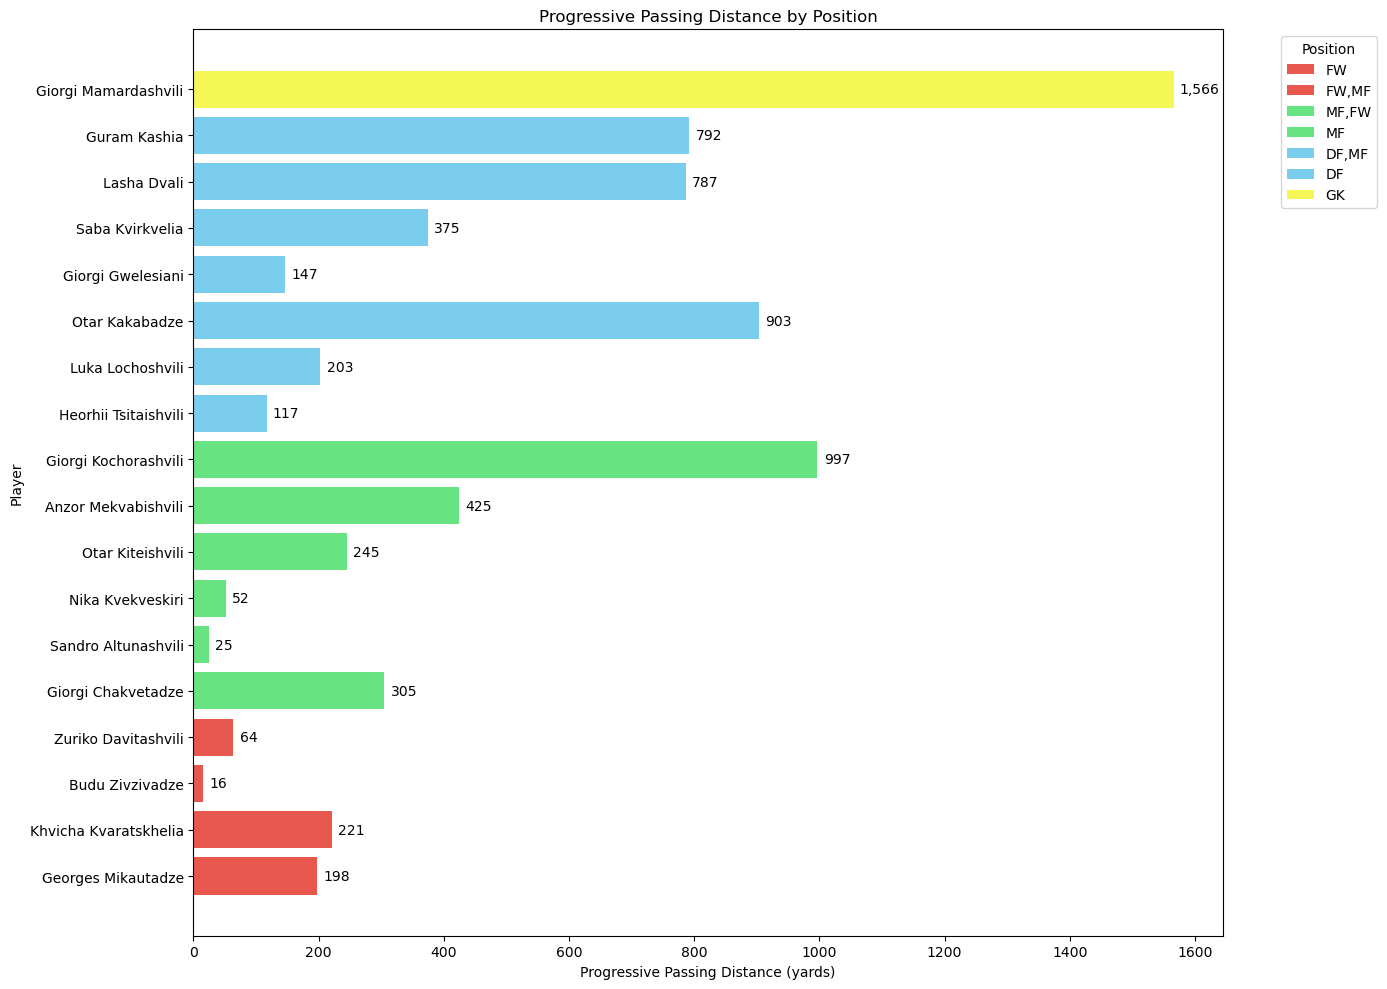

In [51]:
georgia_players = df_pass[df_pass['Squad'] == 'Georgia']
georgia_players = georgia_players[georgia_players['Total_PrgDist'] > 0]

# custom orders
position_order = [
    'FW',
    'FW,MF',
    'MF,FW',
    'MF',
    'DF,MF',
    'DF',
    'GK'
]

position_colors = {
    'FW': '#e8574d',
    'FW,MF': '#e8574d',
    'MF,FW': '#68e381',
    'MF': '#68e381',
    'DF,MF': '#7bcded',
    'DF': '#7bcded',
    'GK': '#f5f757'
}

georgia_players['Pos'] = pd.Categorical(georgia_players['Pos'], categories=position_order, ordered=True)
georgia_players = georgia_players.sort_values(by='Total_PrgDist', ascending=True)

# plotting
fig, ax = plt.subplots(figsize=(14, 10))
for position in position_order:
    pos_players = georgia_players[georgia_players['Pos'] == position]
    bars = ax.barh(pos_players['Player'], pos_players['Total_PrgDist'], color=position_colors.get(position, 'gray'), label=position)

ax.set_xlabel('Progressive Passing Distance (yards)')
ax.set_ylabel('Player')
ax.set_title('Progressive Passing Distance by Position')
ax.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

for bar in ax.patches:
    width = bar.get_width()
    ax.text(width + 10, bar.get_y() + bar.get_height() / 2, f'{width:,}', va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


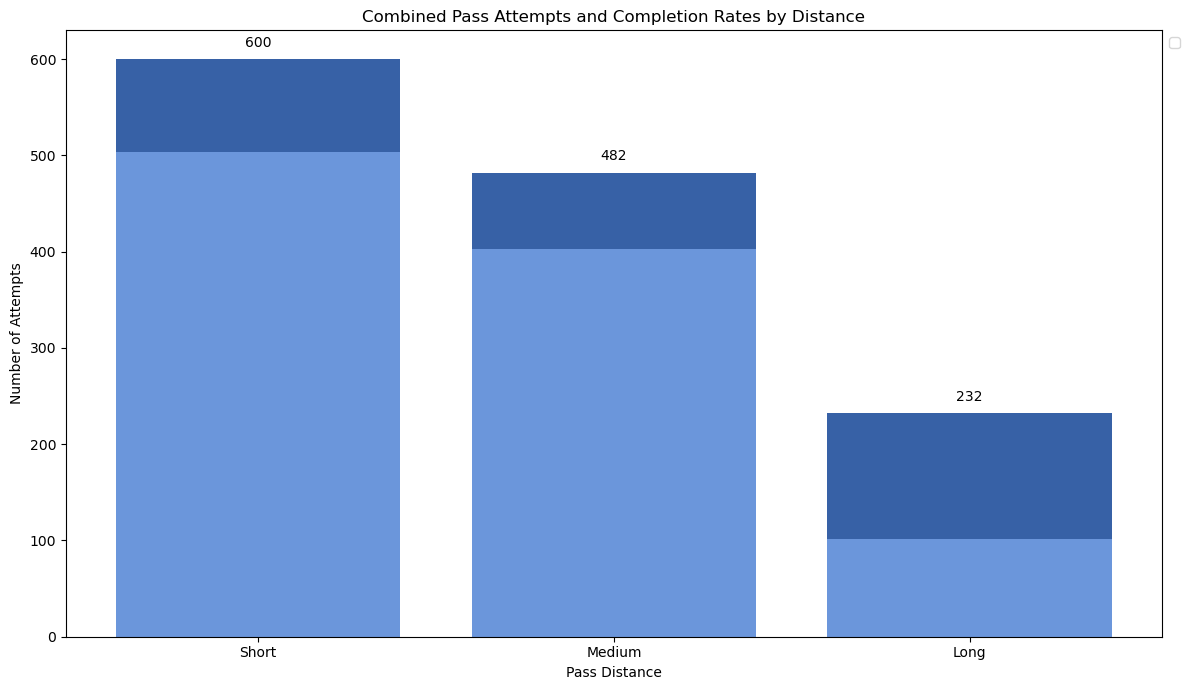

In [52]:
georgian_players = df_pass[df_pass['Squad'] == 'Georgia']

attempts = {
    'Short': georgian_players['Short_Att'].sum(),
    'Medium': georgian_players['Medium_Att'].sum(),
    'Long': georgian_players['Long_Att'].sum()
}

completion_percentages = {
    'Short': georgian_players['Short_Cmp%'].mean(),
    'Medium': georgian_players['Medium_Cmp%'].mean(),
    'Long': georgian_players['Long_Cmp%'].mean()
}

categories = list(attempts.keys())
attempt_values = list(attempts.values())
completion_values = [attempts[cat] * (completion_percentages[cat] / 100) for cat in categories]

# plot
fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.bar(categories, attempt_values, color='#3761a6')

for bar, completion in zip(bars, completion_values):
    ax.bar(bar.get_x() + bar.get_width() / 2, completion, bar.get_width(), color='#6b96db', edgecolor='none')

ax.set_xlabel('Pass Distance')
ax.set_ylabel('Number of Attempts')
ax.set_title('Combined Pass Attempts and Completion Rates by Distance')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

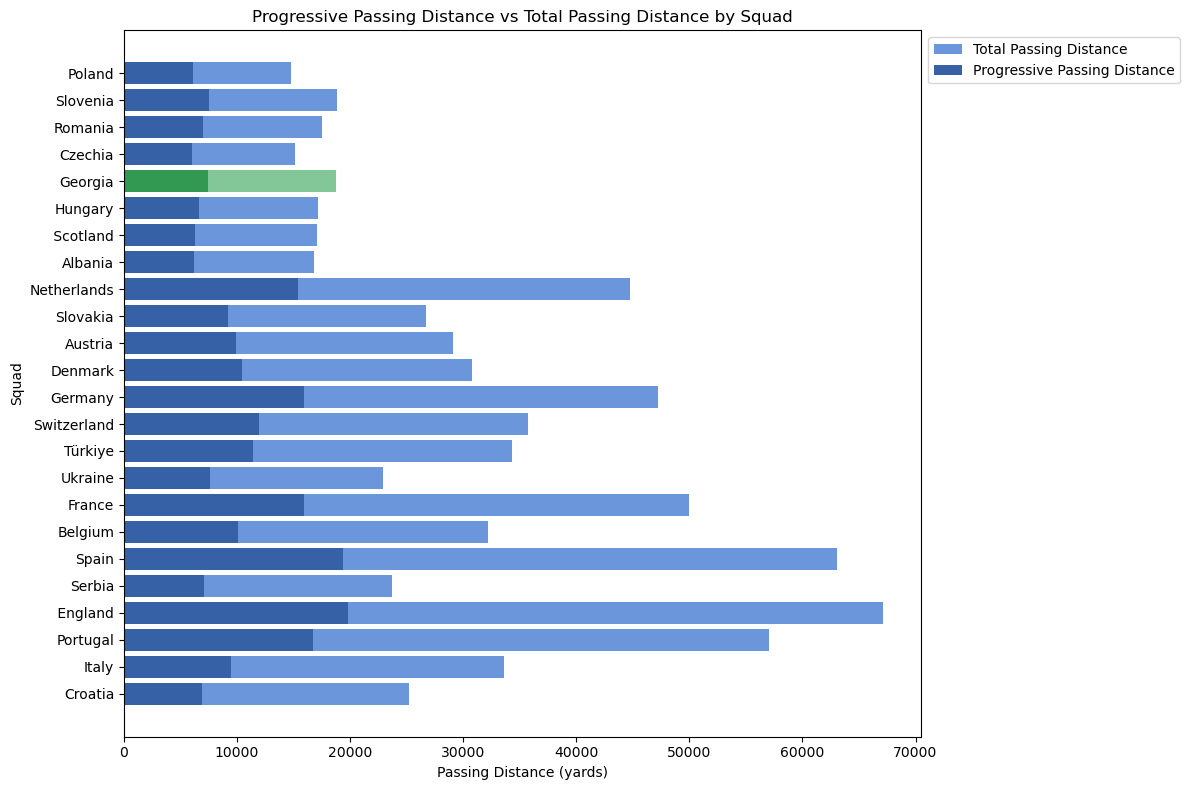

In [53]:
squad_pass_distances = df_pass.groupby('Squad').agg({
    'Total_TotDist': 'sum',
    'Total_PrgDist': 'sum'
}).reset_index()

squad_pass_distances['PrgDist_Percentage'] = (squad_pass_distances['Total_PrgDist'] / squad_pass_distances['Total_TotDist']) * 100

squad_pass_distances = squad_pass_distances.sort_values(by='PrgDist_Percentage', ascending=True)

colors = ['#83c798' if squad == 'Georgia' else '#6b96db' for squad in squad_pass_distances['Squad']]
highlight_color = '#329952'
other_color = '#3761a6'

# plotting
fig, ax = plt.subplots(figsize=(12, 8))

bars_total = ax.barh(squad_pass_distances['Squad'], squad_pass_distances['Total_TotDist'], color=colors, label='Total Passing Distance')

for i, bar in enumerate(bars_total):
    squad_name = squad_pass_distances.iloc[i]['Squad']  # Use index to get squad_name
    prg_dist = squad_pass_distances.loc[squad_pass_distances['Squad'] == squad_name, 'Total_PrgDist'].values[0]
    ax.barh(squad_name, prg_dist, color=highlight_color if squad_name == 'Georgia' else other_color, edgecolor='none', label='Progressive Passing Distance')

ax.set_xlabel('Passing Distance (yards)')
ax.set_ylabel('Squad')
ax.set_title('Progressive Passing Distance vs Total Passing Distance by Squad')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# Shooting

In [54]:
# IMPORTING SHOOTING STATS

response = requests.get('https://fbref.com/en/comps/676/shooting/UEFA-Euro-Stats')
soup = bs4.BeautifulSoup(response.content)
comments = soup.find_all(text=lambda text:isinstance(text, bs4.Comment))
commented_out_tables = [bs4.BeautifulSoup(cmt).find_all('table') for cmt in comments]
commented_out_tables = [tab[0] for tab in commented_out_tables if len(tab) == 1]
df_sh = pd.read_html(str(commented_out_tables[0]))[0]
main_tables = soup.find_all('table')
print(f'Total tables in main HTML: {len(main_tables)}')
print(f'Total tables in comments: {len(commented_out_tables)}')

if commented_out_tables:
    for i, table in enumerate(commented_out_tables):
        df_sh = pd.read_html(str(table))[0]
else:
    print("No tables found in comments.")

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\1553724322.py:5: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\1553724322.py:6: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



Total tables in main HTML: 2
Total tables in comments: 1


In [55]:
# joining multiple index levels 
df_sh.columns = ['_'.join(col) if 'Unnamed' not in col[0] else col[1] for col in df_sh.columns]

# removing country emojis
df_sh['Squad'] = df_sh['Squad'].str[3:]

# getting rid of columns of no significance
df_sh = df_sh.drop(columns=['Rk', 'Matches'])

# index 25 contains no data
df_sh = df_sh.drop(index=25)
df_sh = df_sh.reset_index(drop=True)

# type conversion
columns_to_exclude = ['Player', 'Squad', 'Pos']
columns_to_convert = [col for col in df_sh.columns if col not in columns_to_exclude]
df_sh[columns_to_convert] = df_sh[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# handling fully empty rows
df_sh = df_sh[df_sh['Squad'] != 'ad']

df_sh.head()

,Player,Pos,Squad,Age,Born,90s,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,...,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG
0,Che Adams,FW,Scotland,27.0,1996.0,2.3,0.0,2.0,1.0,50.0,...,0.0,14.1,0.0,0.0,0.0,0.1,0.1,0.06,-0.1,-0.1
1,Michel Aebischer,DF,Switzerland,27.0,1997.0,5.3,1.0,2.0,1.0,50.0,...,1.0,21.7,0.0,0.0,0.0,0.1,0.1,0.05,0.9,0.9
2,Arlind Ajeti,DF,Albania,30.0,1993.0,3.0,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,Manuel Akanji,DF,Switzerland,28.0,1995.0,5.3,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,Samet Akaydın,DF,Türkiye,29.0,1994.0,3.7,1.0,2.0,1.0,50.0,...,1.0,5.2,0.0,0.0,0.0,0.4,0.4,0.18,0.6,0.6


In [56]:
filtered_df = df_sh[(df_sh['Expected_xG'] >= 1) | (df_sh['Standard_Gls'] >= 1)]

jitter_strength = 0.05
filtered_df['Expected_xG'] += np.random.uniform(-jitter_strength, jitter_strength, size=filtered_df.shape[0])
filtered_df['Standard_Gls'] += np.random.uniform(-jitter_strength, jitter_strength, size=filtered_df.shape[0])

georgia_df = filtered_df[filtered_df['Squad'] == 'Georgia']
other_teams_df = filtered_df[filtered_df['Squad'] != 'Georgia']

sh_fig1 = go.Figure()

sh_fig1.add_trace(go.Scatter(
    x=other_teams_df['Expected_xG'],
    y=other_teams_df['Standard_Gls'],
    mode='markers',
    marker=dict(
        size=12,
        color='#2c67c7',
        line=dict(width=2, color='black')
    ),
    text=other_teams_df['Player'],
    hoverinfo='text',
    name='Other Teams'
))

sh_fig1.add_trace(go.Scatter(
    x=georgia_df['Expected_xG'],
    y=georgia_df['Standard_Gls'],
    mode='markers',
    marker=dict(
        size=12,
        color='#32e63e',
        line=dict(width=2, color='black')
    ),
    text=georgia_df['Player'],
    hoverinfo='text',
    name='Georgia'
))

sh_fig1.update_layout(
    title='Most Effective Players: Expected_xG vs Goals',
    xaxis_title='Expected_xG',
    yaxis_title='Goals',
    xaxis=dict(autorange='reversed'),
    showlegend=True,
    width=1200,
    height=800,
    margin=dict(l=100, r=100, t=100, b=100)
)

for i, row in georgia_df.iterrows():
    sh_fig1.add_annotation(
        x=row['Expected_xG'],
        y=row['Standard_Gls'],
        text=row['Player'],
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(size=12, color='black'),
        bgcolor='white',
        borderpad=4,
        bordercolor='black'
    )

sh_fig1.write_html("sh_fig1.html")
sh_fig1.show()

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\1186425293.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Kiu-Student\AppData\Local\Temp\ipykernel_11496\1186425293.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
# precondition: filtering out players with 0 xG
georgian_players = df_sh[(df_sh['Squad'] == 'Georgia') & (df_sh['Expected_xG'] > 0)]

# plotting
sh_fig2 = go.Figure()

sh_fig2.add_trace(go.Scatter(
    x=georgian_players['Standard_Sh'],
    y=georgian_players['Expected_xG'],
    mode='markers',
    marker=dict(
        size=12,
        color='#32e63e', 
        opacity=0.8,
        line=dict(
            width=2,
            color='black'
        )
    )
))

sh_fig2.update_layout(
    title='Georgian Players: Shots vs Expected Goals (xG)',
    xaxis_title='Shots',
    yaxis_title='Expected Goals (xG)',
    width=1200,
    height=800,
    xaxis=dict(
        tickvals=list(range(0, int(georgian_players['Standard_Sh'].max()) + 1, 5)),
        ticktext=[str(i) for i in range(0, int(georgian_players['Standard_Sh'].max()) + 1, 5)]
    ),
    yaxis=dict(
        tickvals=list(range(0, int(georgian_players['Expected_xG'].max()) + 1, 1)),
        ticktext=[str(i) for i in range(0, int(georgian_players['Expected_xG'].max()) + 1, 1)]
    ),
    margin=dict(l=100, r=100, t=100, b=100),
    showlegend=False
)

for i, row in georgian_players.iterrows():
    sh_fig2.add_annotation(
        x=row['Standard_Sh'],
        y=row['Expected_xG'],
        text=row['Player'],
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(size=12, color='black'),
        bgcolor='white',
        borderpad=4,
        bordercolor='black'
    )

sh_fig2.write_html("sh_fig2.html")
sh_fig2.show()

In [58]:
team_stats = df_sh.groupby('Squad').agg({
    'Standard_Dist': 'mean',
    'Standard_Gls': 'sum'
}).reset_index()

team_stats = team_stats.sort_values(by='Standard_Gls', ascending=False)

# generating gradients
num_teams = len(team_stats)
light_red = 20 
dark_red = 200 

gradient_colors = [
    f'rgb(255, {int(light_red - (light_red - dark_red) * i / (num_teams - 1))}, {int(light_red - (light_red - dark_red) * i / (num_teams - 1))})'
    for i in range(num_teams)
]
color_map = {team: '#329952' if team == 'Georgia' else gradient_colors[i] for i, team in enumerate(team_stats['Squad'])}

# plotting
sh_fig3 = go.Figure()

for i, row in team_stats.iterrows():
    sh_fig3.add_trace(go.Bar(
        y=[row['Squad']],
        x=[row['Standard_Dist']],
        orientation='h',
        name=row['Squad'],
        marker_color=color_map[row['Squad']],
        showlegend=False
    ))

# penalty area line at 18 yards
sh_fig3.add_shape(
    type='line',
    x0=16, x1=16,
    y0=-0.5, y1=len(team_stats) - 0.5,
    line=dict(color='black', dash='dash'),
    xref='x', yref='y'
)

sh_fig3.update_layout(
    barmode='stack',
    xaxis_title='Average Shot Distance (meters)',
    yaxis_title='Team',
    title='Average Shot Distance by Team',
    xaxis=dict(
        tickvals=[16],
        ticktext=['Penalty Area'],
        title='Average Shot Distance'
    ),
    yaxis=dict(
        tickvals=[i for i in range(len(team_stats))],
        ticktext=team_stats['Squad'].tolist(),
        autorange='reversed'  # Ensure the y-axis is in descending order
    ),
    width=1000,  # Increase width of the plot
    height=800   # Increase height of the plot
)
sh_fig3.write_html("sh_fig3.html")
sh_fig3.show()